# Indice
1. Deficicion del problema 
2. Preparación de Datos 
3. Elección y Entrenamiento del Modelo
4. Evaluación e Interpretación
5. Presentación del Proyecto

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# 1. Deficicion del problema 

 Construir un modelo de Regresión Lineal Múltiple para predecir la concentración real de Benceno ($\text{C}_6\text{H}_6(\text{GT})$) utilizando las respuestas de sensores químicos y variables ambientales de bajo costo

# 2. Preparación de Datos
### Paso 2.1: Cargar y Explorar el CSV
Carga el archivo CSV (asegúrate de que esté en la misma carpeta o usa la ruta completa).

In [27]:
df = pd.read_csv('AirQualityUCI.csv', sep=';', dtype=str)
df = df.iloc[:-1] # El dataset tiene una última fila con NaN que se debe quitar
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9470 entries, 0 to 9469
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Date           9357 non-null   object
 1   Time           9357 non-null   object
 2   CO(GT)         9357 non-null   object
 3   PT08.S1(CO)    9357 non-null   object
 4   NMHC(GT)       9357 non-null   object
 5   C6H6(GT)       9357 non-null   object
 6   PT08.S2(NMHC)  9357 non-null   object
 7   NOx(GT)        9357 non-null   object
 8   PT08.S3(NOx)   9357 non-null   object
 9   NO2(GT)        9357 non-null   object
 10  PT08.S4(NO2)   9357 non-null   object
 11  PT08.S5(O3)    9357 non-null   object
 12  T              9357 non-null   object
 13  RH             9357 non-null   object
 14  AH             9357 non-null   object
 15  Unnamed: 15    0 non-null      object
 16  Unnamed: 16    0 non-null      object
dtypes: object(17)
memory usage: 1.2+ MB


### Paso 2.2: Limpieza de Datos
1. Manejo del Delimitador Decimal: El dataset usa comas (,) como separador decimal. Debes reemplazar las comas por puntos (.) antes de convertir a numérico.
2. Manejo de Valores Faltantes: Reemplaza el marcador de valor faltante ($\mathbf{-200}$) por $\text{NaN}$ y usa la interpolación lineal para una imputación sensible al tiempo.

In [28]:

for col in df.columns[2:]:
    df[col] = df[col].str.replace(',', '.')
    df[col] = pd.to_numeric(df[col], errors='coerce')

df.replace(-200, np.nan, inplace=True)

df_limpio = df.interpolate(method='linear', limit_direction='both')

C:\Users\DELL J13MXR2\AppData\Local\Temp\ipykernel_21452\202635759.py:7: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_limpio = df.interpolate(method='linear', limit_direction='both')


### Paso 2.3: Feature Engineering y Selección

In [29]:
# Variable Objetivo
y = df_limpio['C6H6(GT)']

# Variables Predictoras (Respuestas de Sensores y Ambientales)
X = df_limpio[['PT08.S2(NMHC)', 'PT08.S1(CO)', 'T', 'RH', 'AH']]

### Paso 2.4: Análisis de Colinealidad (VIF)
Verifica si las variables $X$ están muy correlacionadas entre sí (colinealidad). Valores de VIF > 5 o 10 indican colinealidad fuerte.

In [30]:
# Asegúrate de haber importado: import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Añadir una constante al conjunto de datos para el intercepto
X_vif = sm.add_constant(X)

# Calcular VIF
vif_data = pd.DataFrame()
vif_data['Variable'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]

print("Factor de Inflación de Varianza (VIF):")
print(vif_data.sort_values(by='VIF', ascending=False))

Factor de Inflación de Varianza (VIF):
        Variable        VIF
0          const  91.937276
3              T  12.144086
5             AH   8.174343
4             RH   7.653489
1  PT08.S2(NMHC)   6.483462
2    PT08.S1(CO)   6.286997


### Paso 2.5: Dividir Datos

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 3. Elección y Entrenamiento del Modelo
### Paso 3.1: Entrenar el Modelo
Instanciar y ajustar la Regresión Lineal Múltiple.

In [32]:
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# Obtener predicciones
y_pred = modelo.predict(X_test)

### Paso 3.2: Coeficientes del Modelo
Muestra los coeficientes para la interpretación inicial.

In [33]:
coef_df = pd.DataFrame(modelo.coef_, X.columns, columns=['Coeficiente'])
print("\nCoeficientes del Modelo:")
print(coef_df)
print(f"\nIntercepto (b0): {modelo.intercept_:.2f}")


Coeficientes del Modelo:
               Coeficiente
PT08.S2(NMHC)     0.028193
PT08.S1(CO)      -0.000713
T                -0.072431
RH               -0.010671
AH                0.807912

Intercepto (b0): -14.58


# 4. Evaluación e Interpretación 
### Paso 4.1: Métricas de Evaluación 
Calcula las métricas de regresión clave.

In [34]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n--- Métricas de Evaluación ---")
print(f"R-cuadrado (R²): {r2:.4f}")
print(f"Error Cuadrático Medio (RMSE): {rmse:.2f}")
print(f"Error Absoluto Medio (MAE): {mae:.2f}")


--- Métricas de Evaluación ---
R-cuadrado (R²): 0.9663
Error Cuadrático Medio (RMSE): 1.40
Error Absoluto Medio (MAE): 0.98


### Paso 4.2: Interpretación de Resultados
El valor de $\mathbf{R^2} = 0.96$ indica que el modelo explica el $96\%$ de la variabilidad en la concentración de Benceno. El $\mathbf{RMSE}$ de $1.25$ significa que, en promedio, la predicción del modelo se desvía en $1.25 \mu\text{g/m}^3$ de la concentración real de Benceno.

# 5. Presentación del Proyecto

### Paso 5.1: Diagnóstico de Residuos
Calcula los residuos y realiza los gráficos de diagnóstico.

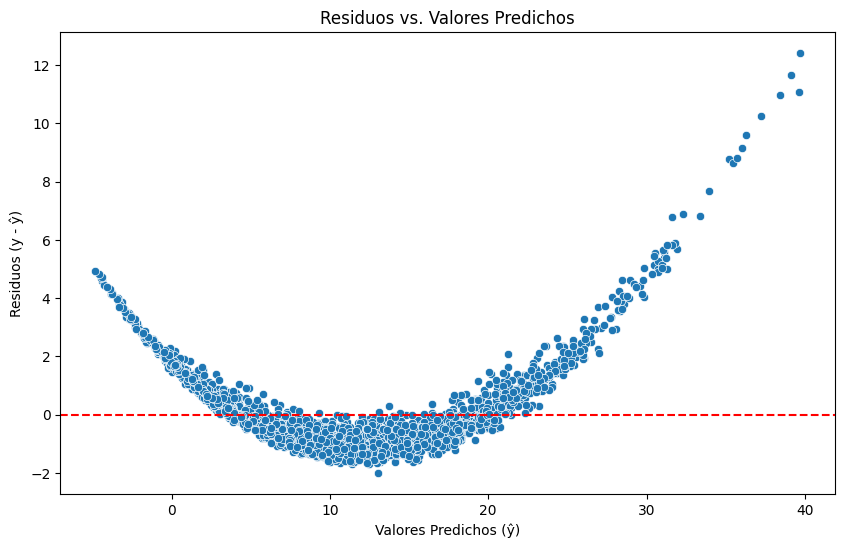

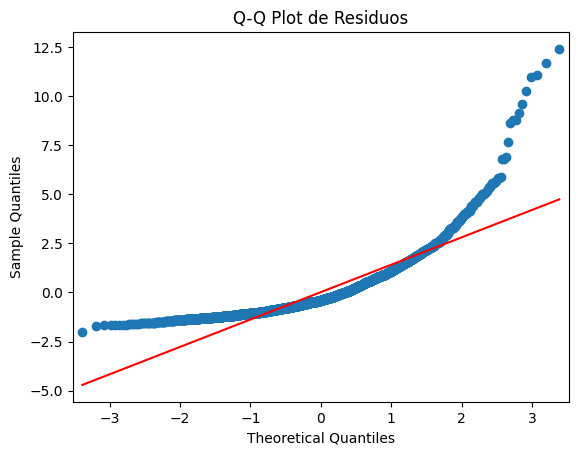

In [35]:
residuos = y_test - y_pred

# 1. Gráfico de Residuos vs. Valores Ajustados (Homocedasticidad)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuos)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuos vs. Valores Predichos')
plt.xlabel('Valores Predichos (ŷ)')
plt.ylabel('Residuos (y - ŷ)')
plt.show()

# 2. Gráfico Q-Q (Normalidad de Residuos)
sm.qqplot(residuos, line='s')
plt.title('Q-Q Plot de Residuos')
plt.show()

### Paso 5.2: Comparación Real vs. Predicho

Visualiza cómo se alinean las predicciones con los valores reales.

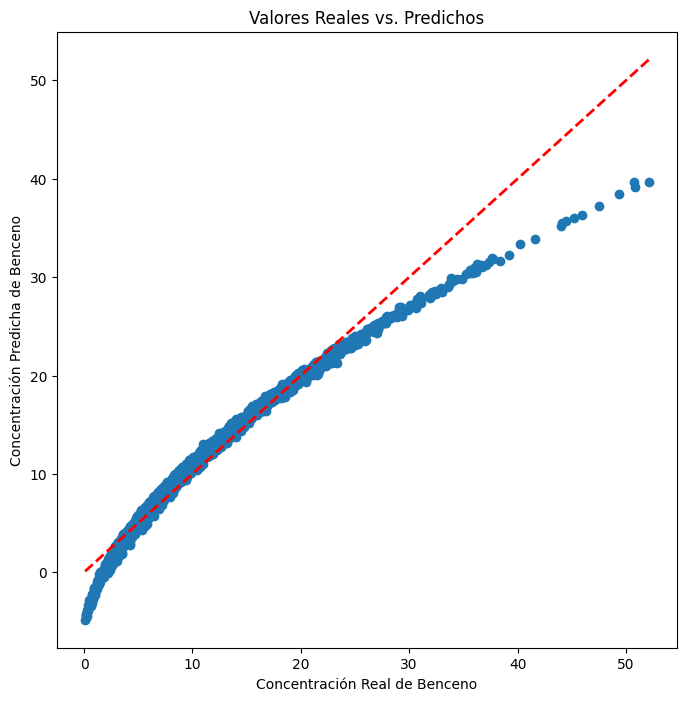

In [36]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Valores Reales vs. Predichos')
plt.xlabel('Concentración Real de Benceno')
plt.ylabel('Concentración Predicha de Benceno')
plt.show()